# Import dependencies and determine working directory

In [1]:
# Import libraries
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wordcloud

# Import NLP dictionaries
import nltk
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# get current directory
dir = os.path.dirname(os.path.abspath('__file__'))

In [3]:
# Get stop words 
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chriskhoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Add neutral words related to restaurants to list of stop words
stopWords.update(['restaurant', 'place', 'bar', 'service', 'food', 'lunch', 'breakfast', 'dinner', 'price', 'order', 'ordered'])

# Remove stopwords that might reflect sentiment
stopWords = [word for word in stopWords if word not in ['above', 'not', 'below', 't', 'off', 'no', 'again', 'against', 'under']]
print(stopWords)

['their', 'and', 'too', 'once', 'you', 'o', 'my', 'or', 'hadn', 'up', 'is', 'all', 'so', 'this', 'into', 'herself', 'do', 'ma', 'food', 'those', 'shan', 'before', 'should', 'more', 'order', 'to', 'me', 'himself', 'will', 'by', 'than', 'from', 'just', 'only', 'restaurant', 'they', 'having', 'had', 're', 'hasn', 'few', 'was', 'he', 'won', 'yours', 'but', 'been', 'while', 'very', 'am', 'breakfast', 'of', 'can', 'for', 'about', 'further', 'it', 'being', 'i', 'theirs', 'myself', 'couldn', 'wasn', 'when', 'both', 'in', 'where', 'how', 'mustn', 'out', 'don', 's', 'him', 'doing', 'with', 'place', 'her', 'has', 'll', 'itself', 'lunch', 'what', 'down', 'the', 'then', 'such', 've', 'whom', 'm', 'haven', 'price', 'same', 'hers', 'if', 'are', 'does', 'were', 'own', 'mightn', 'on', 'service', 'some', 'a', 'she', 'ourselves', 'between', 'each', 'themselves', 'over', 'which', 'your', 'isn', 'other', 'did', 'be', 'wouldn', 'needn', 'shouldn', 'who', 'ordered', 'now', 'after', 'weren', 'aren', 'didn', '

# Load review data

In [5]:
# Load review data 
# Raw data in the format of {} {} {} seperated by lines

# get file path (generalize for different OS) for reviews
filename_review = os.path.join(dir, '01_raw_data','review.json')

# create a list of reviews
with open(filename_review, encoding="utf8", mode='r') as file:
    reviews = [json.loads(line) for line in file]

# create a pandas data frame from review data 
reviews_df = pd.DataFrame(reviews)

# Load business data

In [6]:
# Load business data 

# get file path (generalize for different OS) for reviews
filename_business = os.path.join(dir, '01_raw_data','business.json')

# create a list of reviews
with open(filename_business, encoding="utf8", mode='r') as file:
    businesses = [json.loads(line) for line in file]

# create a pandas data frame from review data 
businesses_df = pd.DataFrame(businesses)

# Merge and pre-process data frames for ngram analysis

In [7]:
# convert date to a datetime - note stars will be kept as an integer vs category
reviews_df['date'] = pd.to_datetime(reviews_df['date'], format='%Y-%m-%d')

In [8]:
# Extract restaurants 
restaurants_df = businesses_df[ businesses_df['categories'].apply(lambda categories: any(pd.Series(categories).str.contains('Restaurants')) if len(categories)>0 else False)]

In [9]:
# Restrict restaurants to the USA using a bounding box 
restaurants_df = restaurants_df[ (restaurants_df['latitude'] >= 24.7433195) & (restaurants_df['latitude'] <= 49.3457868) & (restaurants_df['longitude'] >= -124.7844079) & (restaurants_df['longitude'] <= -66.9513812)]

In [10]:
# Merge both data frames
joint_df = pd.merge(reviews_df, restaurants_df, on='business_id', suffixes=['_review', '_business'])

Note that there was no pre-processing for text to avoid distortion of the data

In [11]:
# drop excess columns
dropped_columns = ['address','city','hours', 'is_open','neighborhood','postal_code', 'state', 'latitude', 'longitude', 'review_id', 'name', 'attributes', 'categories', 'business_id', 'cool', 'funny', 'useful']
for column in dropped_columns:
    del joint_df[column]

In [12]:
# set the date as an index
joint_df.set_index('date', inplace=True)

## Explore the various aspects of the reviews

In [13]:
print(joint_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2876509 entries, 2017-06-03 to 2016-06-24
Data columns (total 5 columns):
stars_review      int64
text              object
user_id           object
review_count      int64
stars_business    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 131.7+ MB
None


### Monthly volume of reviews over time

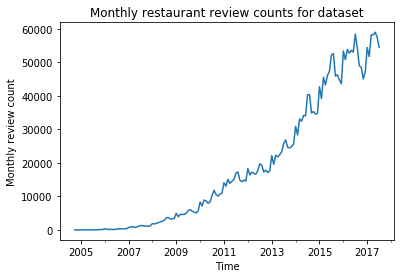

Reviews have grown substantially till 2015. Since 2015, review volume remains high with slower growth


In [15]:
# time series of reviews per week
weekly_reviews = joint_df['stars_review'].resample('M').count()
weekly_reviews.plot( )
plt.title('Monthly restaurant review counts for dataset')
plt.xlabel('Time')
plt.ylabel('Monthly review count')
plt.show()

print('Reviews have grown substantially till 2015. Since 2015, review volume remains high with slower growth')

### Distribution of star ratings for reviews in the dataset

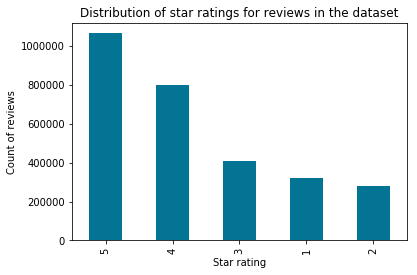

Expected value: 
3.7004935496464637
5    1066341
4     801314
3     408723
1     318889
2     281242
Name: stars_review, dtype: int64

5 star ratings are most common, 3 2 1 star ratings combined make approximately 1/3 of all reviews


In [17]:
# bar char of review stars 
review_stars = joint_df['stars_review'].value_counts()
review_stars.plot(kind='bar', color='#047495')
plt.title('Distribution of star ratings for reviews in the dataset')
plt.xlabel('Star rating')
plt.ylabel('Count of reviews')
plt.show()

print( 'Expected value: ')
print( sum( (review_stars.index.values *review_stars)/ sum(review_stars) ))
print(review_stars)
print('')
print('5 star ratings are most common, 3 2 1 star ratings combined make approximately 1/3 of all reviews')

### Distribution of restaurants by restaurant star ratings

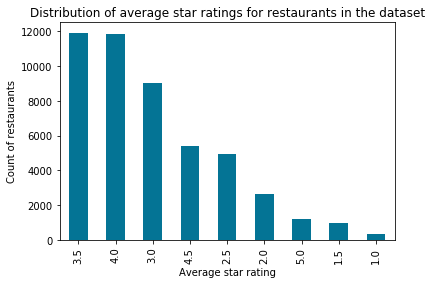

Expected value: 
3.438574275512746
Majority of restaurants have 3-4 star ratings


In [18]:
# distrubtion of restaurants in the dataset by average star ratings 
restaurant_stars = restaurants_df['stars'].value_counts()
restaurant_stars.plot(kind='bar', color='#047495')
plt.title('Distribution of average star ratings for restaurants in the dataset')
plt.xlabel('Average star rating')
plt.ylabel('Count of restaurants')
plt.show()

print( 'Expected value: ')
print( sum( (restaurant_stars.index.values *restaurant_stars)/ sum(restaurant_stars) ))

print('Majority of restaurants have 3-4 star ratings')

### Distribution of reviews by restaurant star ratings

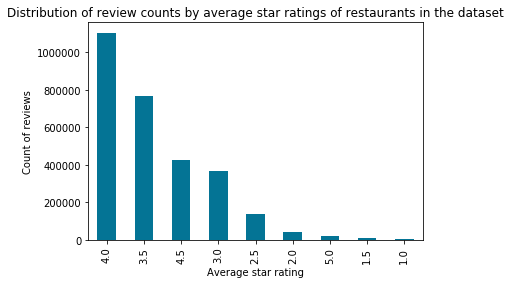

Expected value: 
3.7035773223723623
1.0     6.156352
1.5    12.099581
2.0    16.701788
2.5    28.203805
3.0    40.959413
3.5    64.313329
4.0    93.098271
4.5    78.331295
5.0    15.906091
dtype: float64
Restaurants with higher ratings (4.5 and 4) average more reviews than restaurants with lower (3.5 and below) ratings


In [20]:
# distrubtion of number of reviews by average star rating of restaurant
restaurant_stars_reviews = joint_df['stars_business'].value_counts()
restaurant_stars_reviews.plot(kind='bar', color='#047495')
plt.title('Distribution of review counts by average star ratings of restaurants in the dataset')
plt.xlabel('Average star rating')
plt.ylabel('Count of reviews')
plt.show()

print( 'Expected value: ')
print( sum( (restaurant_stars_reviews.index.values *restaurant_stars_reviews)/ sum(restaurant_stars_reviews) ))
print(restaurant_stars_reviews/restaurant_stars)
print('Restaurants with higher ratings (4.5 and 4) average more reviews than restaurants with lower (3.5 and below) ratings')

### Distribution of restaurants by number of reviews received

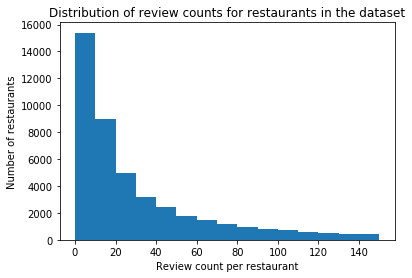

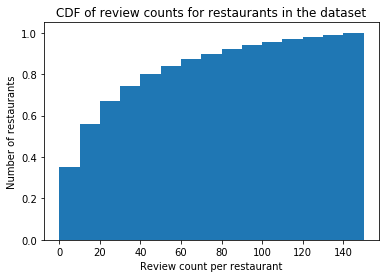

Majority ( 50.6 % ) of restaurants have less than 20 reviews
Few ( 14.6 % ) of restaurants have over 100 reviews


In [23]:
# distrubtion of number of reviews for restaurants in the dataset 
restaurant_reviews = restaurants_df['review_count']
restaurant_reviews.plot(kind='hist', bins = 15, range = (0,150))
plt.title('Distribution of review counts for restaurants in the dataset')
plt.xlabel('Review count per restaurant')
plt.ylabel('Number of restaurants')
plt.show()

restaurant_reviews.plot(kind='hist', cumulative=True, normed=True, bins = 15, range = (0,150))
plt.title('CDF of review counts for restaurants in the dataset')
plt.xlabel('Review count per restaurant')
plt.ylabel('Number of restaurants')
plt.show()

print( 'Majority (', round(100*len(restaurant_reviews[restaurant_reviews< 20])/ len(restaurant_reviews),1), '% ) of restaurants have less than 20 reviews' )
print( 'Few (', round(100*len(restaurant_reviews[restaurant_reviews > 100])/ len(restaurant_reviews),1), '% ) of restaurants have over 100 reviews' )

### Users and how many reviews they've made

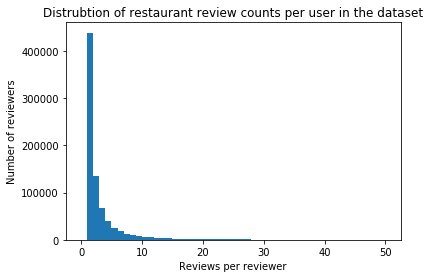

Proportion of reviewers with 1 reviews: 54.40%
Proportion of reviewers with 5 or less reviews: 87.65%
Proportion of reviewers with 10 or less reviews: 94.48%
Proportion of reviewers with 50 or less reviews: 99.39%



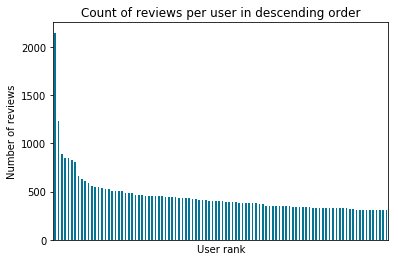

Reviews by top 1900 users: 10.01%
1900 users represent 0.24% of the users who have written reviews
Majority of users have only written a few reviews
The top users have written many reviews


In [24]:
# distrubtion of reviews per user with at least 1 restaurant review in the dataset 
user_reviews = joint_df['user_id'].value_counts()
user_reviews.plot(kind='hist', bins = 50, range = (0,50) )
plt.title('Distrubtion of restaurant review counts per user in the dataset')
plt.xlabel('Reviews per reviewer')
plt.ylabel('Number of reviewers')
plt.show()

print( 'Proportion of reviewers with 1 reviews: %.2f%%' % (100 * len(user_reviews[user_reviews == 1]) / len(user_reviews)) )
print( 'Proportion of reviewers with 5 or less reviews: %.2f%%' % (100 * len(user_reviews[user_reviews <= 5]) / len(user_reviews)) )
print( 'Proportion of reviewers with 10 or less reviews: %.2f%%' % (100 * len(user_reviews[user_reviews <= 10]) / len(user_reviews)) )
print( 'Proportion of reviewers with 50 or less reviews: %.2f%%' % (100 * len(user_reviews[user_reviews <= 50]) / len(user_reviews)) )
print( '' )

user_reviews.head(100).plot(kind='bar', color='#047495')
plt.title('Count of reviews per user in descending order')
plt.xlabel('User rank')
plt.ylabel('Number of reviews')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.show()

print( 'Reviews by top 1900 users: %.2f%%' % ( 100 * sum(user_reviews.head(1900))/joint_df.shape[0] ) )
print( '1900 users represent %.2f%% of the users who have written reviews' % ( 100 * 1900/ len(user_reviews) ) )

print( 'Majority of users have only written a few reviews')
print( 'The top users have written many reviews')

### Analysis on length of review text and its relationship with stars awarded 

In [26]:
# Length of review
joint_df['review_length'] = [ len(text) for text in joint_df['text'] ]

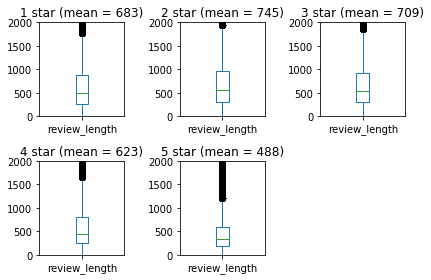

Correlation between stars and length of review text is not obvious.


In [27]:
# Average review length based on the star rating
star_review_lengths = { star: joint_df.review_length[ joint_df['stars_review'] == star] for star in range(1,6) }

for star in range(1,6):
    plt.subplot(2,3,star)
    star_review_lengths[star].plot(kind='box')
    average_length = str( int( round( np.mean(star_review_lengths[star]) , 0) ) )
    plt.title( str(star) + ' star (mean = '+ average_length +')' )
    plt.suptitle("")
    plt.ylim(0, 2000)
    
plt.tight_layout()    
plt.show()

print('Correlation between stars and length of review text is not obvious.')

## Ngram analysis on reviews

## Tri-grams 

In [20]:
# Define tri-grams vectorizer
vectorizer_tri = CountVectorizer(analyzer = 'word',
                             lowercase = True,
                             ngram_range=(3,3),
                             max_features= 4000,
                             max_df=0.95, 
                             min_df=0.0001)

In [21]:
vectorized_tri_text = vectorizer_tri.fit_transform( joint_df['text'] )
print (len(vectorizer_tri.vocabulary_))

4000


for (analyzer = 'word', lowercase = True, ngram_range=(3,3), max_df=0.95, min_df=2 ) 
sparse matrix shape: (2876509, 18191965)
number of non-zeros: 241190131
sparsity: 0.00% - note: cannot hold dense matrix in memory

for (analyzer = 'word', lowercase = True, ngram_range=(3,3), max_df=0.95, min_df=0.0001 ) 
sparse matrix shape: (2876509, 89017)
number of non-zeros: 93639930
sparsity: 0.04% 
(50 mins) - note: cannot hold dense matrix in memory

for (analyzer = 'word', lowercase = True, ngram_range=(3,3), max_df=0.95, min_df=0.01 ) 
sparse matrix shape: (2876509, 104)
number of non-zeros: 5194110
sparsity: 1.74%
(59 mins) 

for (analyzer = 'word', lowercase = True, ngram_range=(3,3), max_features= 5000, max_df=0.95, min_df=0.0001 ) 
sparse matrix shape: (2876509, 5000)
number of non-zeros: 35301741
sparsity: 0.25%

(50 mins) 

In [22]:
# Explore vector metrics
print ('sparse matrix shape:', vectorized_tri_text.shape)
print ('number of non-zeros:', vectorized_tri_text.nnz)
print ('sparsity: %.2f%%' % (100.0 * vectorized_tri_text.nnz / (vectorized_tri_text.shape[0] * vectorized_tri_text.shape[1])))

sparse matrix shape: (2876509, 4000)
number of non-zeros: 32223572
sparsity: 0.28%


In [29]:
# Get list of words in the vocabulary
vocab_tri = vectorizer_tri.get_feature_names()

# Sum up the counts of each vocabulary word
dist_tri = np.sum(vectorized_tri_text.toarray(), axis=0)

# instantiate a vocab dictionary
vocab_count_dictionary_tri = {}

# remove entries that comprise of only stopwords
for entry in zip(vocab_tri, dist_tri):
    if (entry[0].split()[0] not in stopWords) or (entry[0].split()[1] not in stopWords) or (entry[0].split()[2] not in stopWords) :
        vocab_count_dictionary_tri[ entry[0] ] = entry[1]

# convert to pandas series
vocab_count_dictionary_tri = pd.Series( vocab_count_dictionary_tri )

# print most used words
print( vocab_count_dictionary_tri.sort_values( ascending = False) )

one of the              161163
on the menu              98546
of the best              81767
the first time           64627
love this place          64032
in the area              62910
if you want              57686
one of my                57383
will be back             56939
ve ever had              53964
was very good            51515
the staff is             46938
as well as               46911
will definitely be       46493
was good but             45533
is one of                44485
to go back               44399
is the best              43300
it was good              41994
the rest of              40648
we decided to            39733
recommend this place     39432
my husband and           39285
our server was           39138
to try the               39035
it would be              38218
definitely be back       38203
on the side              38011
service was great        37946
the staff was            37842
                         ...  
item on the               3398
to come 

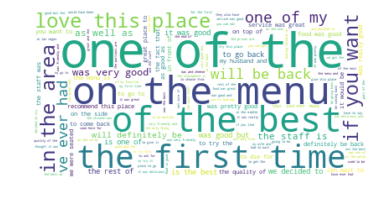

10 minutes for, 10 minutes later, 10 minutes to, 15 minutes for, 15 minutes to, 20 minutes for, 20 minutes to, 30 minutes for, 30 minutes to, able to eat, able to get, about 10 minutes, about 15 minutes, about 20 minutes, about an hour, about the menu, above and beyond, absolutely love this, across the street, added to the, addition to the, after reading the, ahead of time, all can say, all kinds of, all of us, all the dishes, all the time, all the way, along with the, also came with, also got the, also had the, also ordered the, also tried the, also very good, although it was, always fresh and, always friendly and, always get the, always order the, am going to, am not sure, am so glad, amazing and the, amazing food and, amount of food, amount of time, an appetizer and, an hour and, an hour for, an hour to, and ask for, and asked for, and asked if, and attentive the, and both times, and came here, and came with, and can wait, and cheese and, and cheese was, and cooked to, and decided t

on thursday night, on top and, on top of, on us and, on yelp and, one in the, one of my, one of our, one of the, one of their, one of them, one of these, one of those, one or two, one thing that, onion rings and, onion rings were, only complaint is, only downside is, only good thing, only thing that, open 24 hours, opted for the, or at least, order to go, ordered the chicken, other side of, our drink order, our drink orders, our drinks and, our first time, our first visit, our food came, our go to, our meal was, our party of, our server and, our server was, our table and, our table to, our table was, our waiter was, our waitress was, out of town, out the door, outside of the, over an hour, over cooked and, over the menu, over the phone, over the top, over the years, overall it was, overall the food, pad thai and, part of the, pay for the, people at the, people in the, perfect amount of, perfect place to, perfectly cooked and, pick it up, pico de gallo, pizza and the, place is always, p

In [35]:
cloud = wordcloud.WordCloud(stopwords=stopWords, background_color="white", random_state=42).generate_from_frequencies(vocab_count_dictionary_tri)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print(*vocab_count_dictionary_tri.keys(), sep=', ')

## Bi-gram

In [21]:
# Define bi-grams vectorizer
vectorizer_bi = CountVectorizer(analyzer = 'word',
                             lowercase = True,
                             ngram_range=(2,2),
                             max_features= 5000,
                             max_df=0.95, 
                             min_df=0.001)

In [22]:
vectorized_bi_text = vectorizer_bi.fit_transform( joint_df['text'] )
print (len(vectorizer_bi.vocabulary_))

5000


In [23]:
# Explore vector metrics
print ('sparse matrix shape:', vectorized_bi_text.shape)
print ('number of non-zeros:', vectorized_bi_text.nnz)
print ('sparsity: %.2f%%' % (100.0 * vectorized_bi_text.nnz / (vectorized_bi_text.shape[0] * vectorized_bi_text.shape[1])))

sparse matrix shape: (2876509, 5000)
number of non-zeros: 115846263
sparsity: 0.81%


for (analyzer = 'word', lowercase = True, ngram_range=(2,2), max_df=0.95, min_df=0.01 ) 
sparse matrix shape: (2876509, 899)
number of non-zeros: 63598295
sparsity: 2.46%

for (analyzer = 'word', lowercase = True, ngram_range=(2,2), max_df=0.95, min_df=0.001 ) 
sparse matrix shape: (2876509, 12383)
number of non-zeros: 147654827
sparsity: 0.41%
note: cannot hold dense matrix in memory


for (analyzer = 'word', lowercase = True, ngram_range=(2,2), max_features= 6000, max_df=0.95, min_df=0.001 )  
sparse matrix shape: (2876509, 6000)
number of non-zeros: 122128829
sparsity: 0.71%
(15 mins) - note: cannot hold dense matrix in memory

for (analyzer = 'word', lowercase = True, ngram_range=(2,2), max_features= 5500, max_df=0.95, min_df=0.001 ) 
sparse matrix shape: (2876509, 5500)
number of non-zeros: 119120615
sparsity: 0.75%
(15 mins) - note: cannot hold dense matrix in memory

for (analyzer = 'word', lowercase = True, ngram_range=(2,2), max_features= 5000, max_df=0.95, min_df=0.001 ) 
sparse matrix shape: (2876509, 5000)
number of non-zeros: 115846263
sparsity: 0.81%
(15 mins)

In [24]:
# Get list of words in the vocabulary
vocab_bi = vectorizer_bi.get_feature_names()

# Sum up the counts of each vocabulary word
dist_bi = np.sum(vectorized_bi_text.toarray(), axis=0)

# instantiate a vocab dictionary
vocab_count_dictionary_bi = {}

# remove entries that comprise of only stopwords
for entry in zip(vocab_bi, dist_bi):
    if (entry[0].split()[0] not in stopWords) or (entry[0].split()[1] not in stopWords):
        vocab_count_dictionary_bi[ entry[0] ] = entry[1]

# convert to pandas series
vocab_count_dictionary_bi = pd.Series( vocab_count_dictionary_bi )

# print most used words
print( vocab_count_dictionary_bi.sort_values( ascending = False) )

the best              402294
one of                301286
to go                 279397
the menu              270698
to get                270414
to try                236119
was good              221246
as well               207177
was great             183389
very good             179874
to eat                178075
the staff             176878
be back               164482
the chicken           159106
go to                 152885
want to               151133
got the               147758
go back               143037
is great              142436
friendly and          140847
my favorite           135956
good and              133827
going to              132443
good but              132135
would be              131205
first time            130652
my husband            129766
the first             127391
decided to            126239
lot of                126238
                       ...  
of choices              7101
the four                7098
time have               7094
friend who    

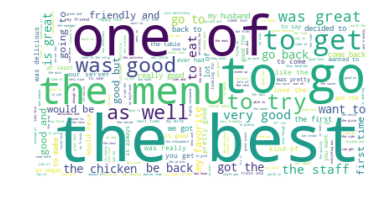

In [25]:
# Build word cloud
cloud = wordcloud.WordCloud(stopwords=stopWords, background_color="white", random_state=42).generate_from_frequencies(vocab_count_dictionary_bi)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Uni-gram

In [5]:
# Load pre-processed data
file_path = os.path.join(dir, '02_processed_data','restaurant_reviews.csv')
pre_processed_joint_df = pd.read_csv(file_path, index_col = False, parse_dates= ['date'])

In [6]:
# Initialize scikit-learn's bag of words tool -  "CountVectorizer"
# Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer = CountVectorizer(analyzer = 'word',
                             max_features= 5000,
                             max_df=0.95, 
                             min_df=0.001)

In [7]:
vectorized_uni_text = vectorizer.fit_transform( pre_processed_joint_df['processed_review'] )
print (len(vectorizer.vocabulary_))

3995


In [8]:
# Explore vector metrics
print ('sparse matrix shape:', vectorized_uni_text.shape)
print ('number of non-zeros:', vectorized_uni_text.nnz)
print ('sparsity: %.2f%%' % (100.0 * vectorized_uni_text.nnz / (vectorized_uni_text.shape[0] * vectorized_uni_text.shape[1])))

sparse matrix shape: (2876509, 3995)
number of non-zeros: 123477793
sparsity: 1.07%


for (analyzer = 'word', max_features= 5000, max_df=0.95, min_df=0.001)
sparse matrix shape: (2876509, 3995)
number of non-zeros: 123477793
sparsity: 1.07%

for (analyzer = 'word', max_df=0.95, min_df=0.0001)




In [12]:
# Get list of words in the vocabulary
vocab_uni = vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
dist_uni = np.sum(vectorized_uni_text.toarray(), axis=0)

# instantiate a vocab dictionary
vocab_count_dictionary_uni = {}

# remove entries that comprise of only stopwords
for entry in zip(vocab_uni, dist_uni):
    if entry[0] not in ['restaurant', 'place', 'bar', 'service', 'food', 'lunch', 'breakfast', 'dinner', 'price', 'order', 'ordered']:
        vocab_count_dictionary_uni[ entry[0] ] = entry[1]

# convert to pandas series
vocab_count_dictionary_uni = pd.Series( vocab_count_dictionary_uni )

# print most used words
print( vocab_count_dictionary_uni.sort_values( ascending = False) )

good            1892858
great           1344620
time            1178872
like            1131077
one             1004655
get              938087
back             863566
go               857214
really           827370
would            821958
also             658247
chicken          643743
menu             595335
got              580615
nice             557659
best             555557
come             543735
well             541939
came             533220
try              531427
delicious        526938
table            519562
even             514624
love             504504
little           479664
drink            474594
sauce            463990
pizza            461284
always           452332
make             438632
                 ...   
friendliness       3007
accordingly        3005
loss               3003
loudly             3003
differently        3002
exist              3000
delivering         2999
measure            2997
biased             2993
encourage          2990
mildly          

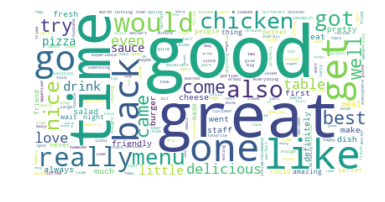

In [13]:
# Build word cloud
cloud = wordcloud.WordCloud(stopwords=stopWords, background_color="white", random_state=42).generate_from_frequencies(vocab_count_dictionary_uni)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Build uni-gram wordclouds by review's star rating

1
sparse matrix shape: (318889, 3943)
number of non-zeros: 14812195
sparsity: 1.18%
best 153
great 60
good 8
ok 118
bad 22
never 10
time     166386
like     146433
one      146228
back     136068
get      133206
would    130360
go       114919
good     113823
even     110069
never    108384
dtype: int64


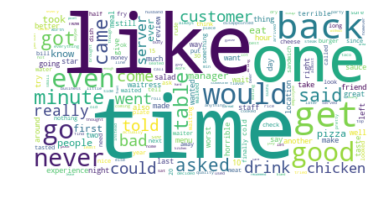

------------------------------
2
sparse matrix shape: (281242, 4291)
number of non-zeros: 14413745
sparsity: 1.19%
best 76
great 16
good 1
ok 50
bad 30
never 48
good      191009
like      157643
time      145173
one       126508
get       117829
would     114565
back      104988
really     99227
go         95065
table      83519
dtype: int64


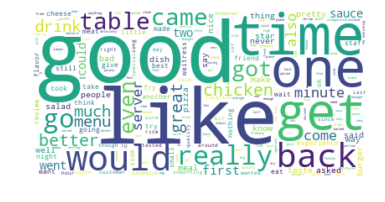

------------------------------
3
sparse matrix shape: (408723, 4314)
number of non-zeros: 20342824
sparsity: 1.15%
best 56
great 8
good 1
ok 35
bad 48
never 110
good      387636
like      216540
time      183458
would     165210
one       158517
get       157038
really    155652
great     146147
go        134921
back      122562
dtype: int64


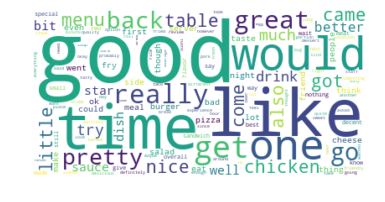

------------------------------
4
sparse matrix shape: (801314, 4044)
number of non-zeros: 36001199
sparsity: 1.11%
best 31
great 2
good 1
ok 251
bad 148
never 97
good      691824
great     447664
like      325232
time      322707
one       279479
really    275310
get       264574
go        234749
would     232493
back      224938
dtype: int64


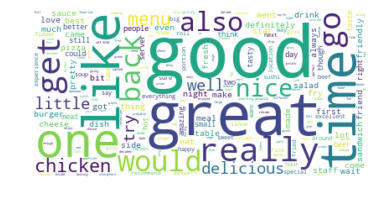

------------------------------
5
sparse matrix shape: (1066341, 3446)
number of non-zeros: 38185390
sparsity: 1.04%
best 4
great 1
good 2
ok 540
bad 221
never 55
great        637882
good         508566
time         361148
best         308421
one          293923
like         285229
delicious    279171
go           277560
back         275010
love         266082
dtype: int64


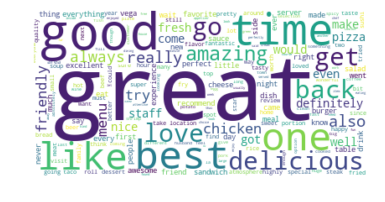

------------------------------


In [6]:
star_review_processed_review = { star: pre_processed_joint_df.processed_review[ pre_processed_joint_df['stars_review'] == star] for star in range(1,6) }

restaurant_neutral_words = ['restaurant', 'place', 'bar', 'service', 'food', 'lunch', 'breakfast', 'dinner', 'price', 'order', 'ordered']

for star in range(1,6):
    vectorizer = CountVectorizer(analyzer = 'word',
                             max_features= 5000,
                             max_df=0.95, 
                             min_df=0.001)
    vectorized_uni_text = vectorizer.fit_transform( star_review_processed_review[ star ] )
    print (star)
    print ('sparse matrix shape:', vectorized_uni_text.shape)
    print ('number of non-zeros:', vectorized_uni_text.nnz)
    print ('sparsity: %.2f%%' % (100.0 * vectorized_uni_text.nnz / (vectorized_uni_text.shape[0] * vectorized_uni_text.shape[1])))
    
    vocab_uni = vectorizer.get_feature_names()
    dist_uni = np.sum(vectorized_uni_text.toarray(), axis=0)
    vocab_count_dictionary_uni = {}
    for entry in zip(vocab_uni, dist_uni):
        if entry[0] not in restaurant_neutral_words:
            vocab_count_dictionary_uni[ entry[0] ] = entry[1]
    vocab_count_dictionary_uni = pd.Series( vocab_count_dictionary_uni )
    
    for word in ['best', 'great', 'good', 'ok', 'bad', 'never']: 
        print( word, str(int(vocab_count_dictionary_uni.rank(ascending=False)[word])) )
        
    # print most used words
    print( vocab_count_dictionary_uni.sort_values( ascending = False).head(10) )
    
    cloud = wordcloud.WordCloud(stopwords=stopWords, background_color="white", random_state=42).generate_from_frequencies(vocab_count_dictionary_uni)
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    print( '------------------------------' )